# news data LDA

In [1]:
import pandas as pd
import numpy as np

import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.manifold import TSNE
# from sklearn.manifold import MDS
# from sklearn.decomposition import PCA
import string
import re
from collections import Counter
from gensim.utils import simple_preprocess
import gensim
from utils import classla_lemmatize, preprocess_text, preprocess_and_lemmatize_news
SEED = 42

ROOT_PATH = '/home/jhladnik/'


## select data that we will work with
If we dont have already preprocessed and lemmatized text we do that

In [10]:
df_all = pd.read_parquet(
    f"{ROOT_PATH}data/eventregistry/df_news_2020.parquet.gzip")

NUM_SAMPLES = 5000
df = df_all.sample(NUM_SAMPLES, random_state=SEED)

# df = df_all[df_all['media']=='MMC RTV Slovenija']
# df


### preprocess text, tokenize and lemmatize

In [11]:
df = preprocess_and_lemmatize_news(df)


2023-01-13 21:21:13 INFO: Loading these models for language: sl (Slovenian):
| Processor | Package     |
---------------------------
| tokenize  | nonstandard |
| pos       | nonstandard |
| lemma     | nonstandard |

2023-01-13 21:21:13 INFO: Use device: gpu
2023-01-13 21:21:13 INFO: Loading: tokenize
2023-01-13 21:21:13 INFO: Loading: pos
2023-01-13 21:21:14 INFO: Loading: lemma
2023-01-13 21:21:16 INFO: Done loading processors!


In [12]:
# save preprocessed df
df.to_parquet(
    f'{ROOT_PATH}/data/eventregistry/df_news_lemmas_{NUM_SAMPLES}.parquet.gzip', compression='gzip')


## LDA on preprocessed, lemmatized news


In [2]:
from gensim.corpora import Dictionary
NUM_SAMPLES = 5000
df = pd.read_parquet(
    f'{ROOT_PATH}/data/eventregistry/df_news_lemmas_{NUM_SAMPLES}.parquet.gzip')

dictionary = Dictionary(list(df['lemmatized_text']))
corpus = [dictionary.doc2bow(text) for text in list(df['lemmatized_text'])]

# pickle.dump(corpus, open('corpus.pkl', 'wb'))
# dictionary.save('dictionary.gensim')


In [20]:
%%time
# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

trained_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=SEED
)


CPU times: user 1min 2s, sys: 152 ms, total: 1min 2s
Wall time: 1min 2s


In [15]:
trained_model.show_topic(1, topn=25)


[('tekma', 0.010025533),
 ('sezona', 0.006507818),
 ('imeti', 0.0054854206),
 ('liga', 0.0053104153),
 ('nov', 0.005286374),
 ('mesto', 0.0051835235),
 ('slovenski', 0.0049637225),
 ('predsednik', 0.0049209027),
 ('klub', 0.0047020814),
 ('zmaga', 0.0043890686),
 ('ekipa', 0.00434169),
 ('svetoven', 0.004233311),
 ('točka', 0.0042081997),
 ('konec', 0.0040621227),
 ('volitev', 0.0034670767),
 ('prvenstvo', 0.003439831),
 ('igralec', 0.003305038),
 ('ZDA', 0.0032185295),
 ('Slovenija', 0.002971029),
 ('igra', 0.002934021),
 ('evropski', 0.0029220898),
 ('Trump', 0.002885204),
 ('prvak', 0.0028789877),
 ('začeti', 0.002825916),
 ('tekmovanje', 0.002791571)]

In [21]:
from evaluation import get_top_words_for_topics_lda, topic_diversity, topic_coherence

topics_representations = get_top_words_for_topics_lda(trained_model, 25)
topics_representations

[['slovenski',
  'nov',
  'spleten',
  'Slovenija',
  'projekt',
  'Ljubljana',
  'delo',
  'podjetje',
  'imeti',
  'Nbsp',
  'svet',
  'tehnologija',
  'različen',
  'pomemben',
  'področje',
  'del',
  'uporaba',
  'razstava',
  'prostor',
  'razvoj',
  'trg',
  'uporabljati',
  'sistem',
  'izdelek',
  'telefon'],
 ['tekma',
  'sezona',
  'imeti',
  'liga',
  'nov',
  'mesto',
  'slovenski',
  'predsednik',
  'klub',
  'zmaga',
  'ekipa',
  'svetoven',
  'točka',
  'konec',
  'volitev',
  'prvenstvo',
  'igralec',
  'ZDA',
  'Slovenija',
  'igra',
  'evropski',
  'Trump',
  'prvak',
  'začeti',
  'tekmovanje'],
 ['vlada',
  'evro',
  'Slovenija',
  'država',
  'odstotek',
  'podjetje',
  'imeti',
  'nov',
  'zakon',
  'čas',
  'delo',
  'milijon',
  'evropski',
  'javen',
  'predsednik',
  'slovenski',
  'minister',
  'policist',
  'Ljubljana',
  'državen',
  'policija',
  'sodišče',
  'stranka',
  'predlog',
  'iti'],
 ['imeti',
  'čas',
  'človek',
  'življenje',
  'zato',
  'iti

### calculate topic diversity

In [22]:
topic_diversity(topics_representations, 25)

0.784

### calculate topic coherence


In [2]:
topic_coherence(trained_model, topics_representations, top_k_words=10)

In [89]:
topics = trained_model.print_topics(num_words=15)
for topic in topics:
    print(topic)


(0, '0.016*"nov" + 0.015*"okužba" + 0.011*"človek" + 0.010*"država" + 0.010*"koronavirus" + 0.008*"dan" + 0.008*"več" + 0.007*"ukrep" + 0.006*"primer" + 0.006*"okužen" + 0.006*"lahko" + 0.006*"število" + 0.006*"imeti" + 0.006*"covid" + 0.005*"potrditi"')
(1, '0.013*"leto" + 0.007*"imeti" + 0.006*"lahko" + 0.004*"čas" + 0.004*"film" + 0.004*"velik" + 0.004*"slovenski" + 0.004*"zelo" + 0.004*"iti" + 0.004*"nov" + 0.003*"delo" + 0.003*"več" + 0.003*"dober" + 0.003*"svet" + 0.003*"sam"')
(2, '0.007*"vlada" + 0.007*"Slovenija" + 0.006*"leto" + 0.006*"imeti" + 0.006*"lahko" + 0.005*"evro" + 0.005*"delo" + 0.004*"nov" + 0.004*"ukrep" + 0.004*"čas" + 0.004*"odstotek" + 0.004*"zakon" + 0.004*"javen" + 0.004*"ministrstvo" + 0.003*"glede"')
(3, '0.015*"tekma" + 0.009*"sezona" + 0.008*"imeti" + 0.008*"točka" + 0.007*"minuta" + 0.007*"dober" + 0.007*"liga" + 0.006*"ekipa" + 0.006*"zmaga" + 0.006*"zadnji" + 0.005*"konec" + 0.005*"leto" + 0.005*"igra" + 0.005*"mesto" + 0.004*"igralec"')
(4, '0.009*"Z

In [81]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(trained_model, corpus, dictionary)
pyLDAvis.save_html(lda_viz, 'lda_news.html')


c:\Users\hladn\anaconda3\envs\torchtest\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### LDA parameter evaluation

In [3]:
from gensim.corpora import Dictionary
NUM_SAMPLES = 5000
df = pd.read_parquet(
    f'{ROOT_PATH}/data/eventregistry/df_news_lemmas_{NUM_SAMPLES}.parquet.gzip')

dictionary = Dictionary(list(df['lemmatized_text']))
corpus = [dictionary.doc2bow(text) for text in list(df['lemmatized_text'])]


In [5]:
%%time
from evaluation import get_top_words_for_topics_lda, topic_diversity, topic_coherence

# Set training parameters.
#num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

results_dict = {"model_name": [], "num_topics": [],
 "topic_diversity": [], "topic_coherence": [], "seed":[]}



for seed in [1, 2, 3]:
    for num_topics in [5, 8, 10, 15, 20, 30, 40, 50, 100]:
        print(f"num_topics: {num_topics}")
        trained_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
            random_state=seed
        )

        topics_representations = get_top_words_for_topics_lda(trained_model, 25)
        results_dict["model_name"].append("LDA")
        results_dict["num_topics"].append(num_topics)
        results_dict["topic_diversity"].append(topic_diversity(topics_representations, 25))
        results_dict["topic_coherence"].append(topic_coherence(df, trained_model, topics_representations, top_k_words=10))
        results_dict["seed"].append(seed)

df_results = pd.DataFrame(results_dict)
df_results.to_csv(f"{ROOT_PATH}/masters-thesis/notebooks/lda_news_results_{NUM_SAMPLES}.csv", index=False)

num_topics: 5
num_topics: 8
num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 30
num_topics: 40
num_topics: 50
num_topics: 100
num_topics: 5
num_topics: 8
num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 30
num_topics: 40
num_topics: 50
num_topics: 100
num_topics: 5
num_topics: 8
num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 30
num_topics: 40
num_topics: 50
num_topics: 100
CPU times: user 6h 51min 45s, sys: 1d 3h 39min 9s, total: 1d 10h 30min 55s
Wall time: 1h 5min 53s


<AxesSubplot:xlabel='num_topics', ylabel='topic_diversity'>

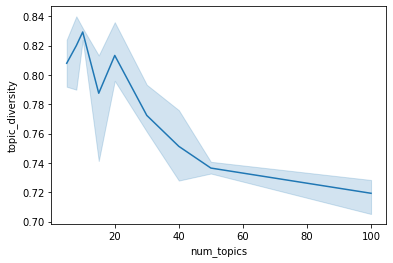

In [7]:
import seaborn as sns

sns.lineplot(data=df_results, x="num_topics", y="topic_diversity")

## NMF on preprocessed, lemmatized news

In [26]:
%%time
## NMF on preprocessed, lemmatized tweets


from gensim.corpora import Dictionary
NUM_SAMPLES = 50000
df = pd.read_parquet(
    f'{ROOT_PATH}/data/eventregistry/df_news_lemmas_{NUM_SAMPLES}.parquet.gzip')

dictionary = Dictionary(list(df['lemmatized_text']))
corpus = [dictionary.doc2bow(text) for text in list(df['lemmatized_text'])]

# pickle.dump(corpus, open('corpus.pkl', 'wb'))
# dictionary.save('dictionary.gensim')

dictionary[0]
# Set training parameters.
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

trained_model = gensim.models.Nmf(
    corpus=corpus,
    id2word=id2word,
    #chunksize=chunksize,
    #alpha='auto',
    #eta='auto',
    #iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=SEED
)


CPU times: user 19min 18s, sys: 1h 4min 33s, total: 1h 23min 51s
Wall time: 2min 32s


In [27]:
trained_model.show_topic(1, topn=25)


[('imeti', 0.06502190266760312),
 ('čas', 0.008982282088606255),
 ('iti', 0.006717101022843348),
 ('težava', 0.006542250286260142),
 ('zato', 0.006462214787708607),
 ('vedeti', 0.006039601668223968),
 ('star', 0.005781164162157166),
 ('priti', 0.005474417178107118),
 ('povedati', 0.005093580724865766),
 ('delati', 0.005069928076582149),
 ('treba', 0.004738637726957009),
 ('dobiti', 0.004470959722024469),
 ('bolnik', 0.0042341271391254124),
 ('narediti', 0.003916657776025324),
 ('potrebovati', 0.0038885896660588786),
 ('reči', 0.003345804637816599),
 ('bolezen', 0.003126408396511405),
 ('videti', 0.003049677590540421),
 ('dom', 0.002976078703645186),
 ('zdravnik', 0.0029298509508246173),
 ('doma', 0.002890760362294878),
 ('pomeniti', 0.00279433047633452),
 ('sistem', 0.0027376765334190577),
 ('pomemben', 0.002714354344922804),
 ('dati', 0.002691461075932768)]

In [28]:
from evaluation import get_top_words_for_topics_lda, topic_diversity

topics_representations = get_top_words_for_topics_lda(trained_model, 25)
topics_representations

[['vlada',
  'stranka',
  'predsednik',
  'Janša',
  'minister',
  'predlog',
  'poslanec',
  'zakon',
  'državen',
  'političen',
  'medij',
  'koalicija',
  'volitev',
  'Janez',
  'javen',
  'ukrep',
  'SDS',
  'skupina',
  'Slovenija',
  'seja',
  'epidemija',
  'dejati',
  'čas',
  'levica',
  'sodišče'],
 ['imeti',
  'čas',
  'iti',
  'težava',
  'zato',
  'vedeti',
  'star',
  'priti',
  'povedati',
  'delati',
  'treba',
  'dobiti',
  'bolnik',
  'narediti',
  'potrebovati',
  'reči',
  'bolezen',
  'videti',
  'dom',
  'zdravnik',
  'doma',
  'pomeniti',
  'sistem',
  'pomemben',
  'dati'],
 ['vozilo',
  'spleten',
  'policist',
  'podatek',
  'piškotek',
  'policija',
  'uporabnik',
  'avtomobil',
  'uporaba',
  'voznik',
  'uporabljati',
  'sistem',
  'omogočati',
  'aplikacija',
  'naprava',
  'tovrsten',
  'informacija',
  'prometen',
  'nesreča',
  'vožnja',
  'tehnologija',
  'policijski',
  'oseben',
  'cesta',
  'električen'],
 ['odstotek',
  'odstoten',
  'lani',
  'i

### calculate topic diversity

In [29]:


topic_diversity(topics_representations, 25)

0.654

### calculate topic coherence


In [30]:
from gensim.models import CoherenceModel


In [32]:

topic_coherence(trained_model, topics_representations, top_k_words=25)

0.07282392241152802

In [33]:
topics = trained_model.print_topics(num_words=15)
for topic in topics:
    print(topic)


(0, '0.036*"vlada" + 0.015*"stranka" + 0.012*"predsednik" + 0.009*"Janša" + 0.008*"minister" + 0.008*"predlog" + 0.007*"poslanec" + 0.007*"zakon" + 0.007*"državen" + 0.006*"političen" + 0.006*"medij" + 0.006*"koalicija" + 0.006*"volitev" + 0.006*"Janez" + 0.005*"javen"')
(1, '0.065*"imeti" + 0.009*"čas" + 0.007*"iti" + 0.007*"težava" + 0.006*"zato" + 0.006*"vedeti" + 0.006*"star" + 0.005*"priti" + 0.005*"povedati" + 0.005*"delati" + 0.005*"treba" + 0.004*"dobiti" + 0.004*"bolnik" + 0.004*"narediti" + 0.004*"potrebovati"')
(2, '0.010*"vozilo" + 0.009*"spleten" + 0.008*"policist" + 0.007*"podatek" + 0.007*"piškotek" + 0.007*"policija" + 0.006*"uporabnik" + 0.006*"avtomobil" + 0.006*"uporaba" + 0.005*"voznik" + 0.005*"uporabljati" + 0.005*"sistem" + 0.005*"omogočati" + 0.004*"aplikacija" + 0.004*"naprava"')
(3, '0.103*"odstotek" + 0.014*"odstoten" + 0.009*"lani" + 0.009*"indeks" + 0.008*"rast" + 0.007*"točka" + 0.007*"primerjava" + 0.007*"raziskava" + 0.006*"dolar" + 0.006*"število" + 0.0

In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(trained_model, corpus, dictionary)
pyLDAvis.save_html(lda_viz, 'lda_news.html')


ModuleNotFoundError: No module named 'pyLDAvis'

### NMF parameter evaluation

In [ ]:
from gensim.corpora import Dictionary
NUM_SAMPLES = 5000
df = pd.read_parquet(
    f'{ROOT_PATH}/data/eventregistry/df_news_lemmas_{NUM_SAMPLES}.parquet.gzip')

dictionary = Dictionary(list(df['lemmatized_text']))
corpus = [dictionary.doc2bow(text) for text in list(df['lemmatized_text'])]


In [9]:
%%time
from evaluation import get_top_words_for_topics_lda, topic_diversity, topic_coherence

# Set training parameters.
#num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

results_dict = {"model_name": [], "num_topics": [],
 "topic_diversity": [], "topic_coherence": [], "seed":[]}



for seed in [1, 2, 3]:
    for num_topics in [5, 8, 10, 15, 20, 30, 40, 50, 100]:
        print(f"num_topics: {num_topics}")
        trained_model = gensim.models.Nmf(
            corpus=corpus,
            id2word=id2word,
            #chunksize=chunksize,
            #alpha='auto',
            #eta='auto',
            #iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
            random_state=seed
        )


        topics_representations = get_top_words_for_topics_lda(trained_model, 25)
        results_dict["model_name"].append("NMF")
        results_dict["num_topics"].append(num_topics)
        results_dict["topic_diversity"].append(topic_diversity(topics_representations, 25))
        results_dict["topic_coherence"].append(topic_coherence(df, trained_model, topics_representations, top_k_words=10))
        results_dict["seed"].append(seed)

df_results_nmf = pd.DataFrame(results_dict)
df_results_nmf.to_csv(f"{ROOT_PATH}/masters-thesis/notebooks/nmf_news_results_{NUM_SAMPLES}.csv", index=False)

num_topics: 5
num_topics: 8
num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 30
num_topics: 40
num_topics: 50
num_topics: 100
num_topics: 5
num_topics: 8
num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 30
num_topics: 40
num_topics: 50
num_topics: 100
num_topics: 5
num_topics: 8
num_topics: 10
num_topics: 15
num_topics: 20
num_topics: 30
num_topics: 40
num_topics: 50
num_topics: 100
CPU times: user 1h 40min 48s, sys: 4h 39min 8s, total: 6h 19min 57s
Wall time: 12min 3s


In [15]:

df_results_nmf


<AxesSubplot:xlabel='num_topics', ylabel='topic_diversity'>

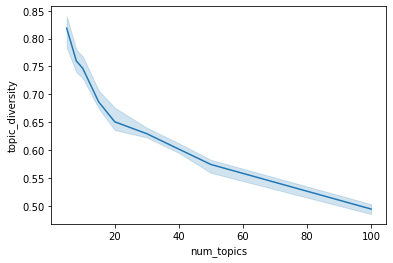

In [18]:
import seaborn as sns

sns.lineplot(data=df_results_nmf, x="num_topics", y="topic_diversity")


## NMF and LDA comparison

<AxesSubplot:xlabel='num_topics', ylabel='topic_diversity'>

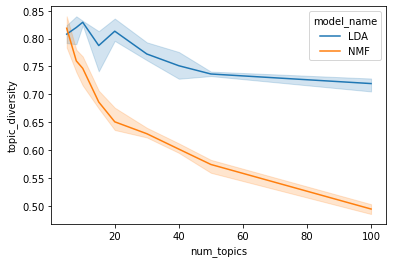

In [20]:
df_both = pd.concat([df_results, df_results_nmf], axis=0)
sns.lineplot(data=df_both, x="num_topics", y="topic_diversity", hue="model_name")

<AxesSubplot:xlabel='num_topics', ylabel='topic_coherence'>

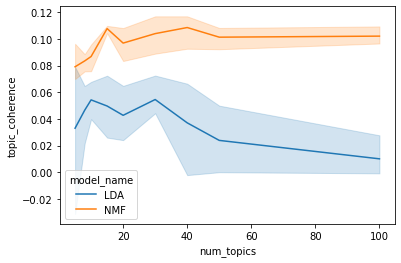

In [21]:
sns.lineplot(data=df_both, x="num_topics", y="topic_coherence", hue="model_name")